In [1]:
# imports
import tensorflow as tf
from tensorflow import keras
import numpy as np
import warnings

warnings.filterwarnings('ignore')

2025-04-18 14:56:18.353299: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-18 14:56:18.475201: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# global variables

context_window = 256
batch_size = 64
n_embd = 384
n_heads = 6
n_epochs = 3000
n_blocks = 6
lr = 3e-4
dropout = 0.2

In [3]:
# load & read dataset
with open("tiny_shakesphere.txt", "r") as file:
    text = file.read()

# extract vocab size
chars = list(sorted(set(text)))
vocab_size = len(chars)

In [4]:
# build token encoder & decoder
chartoindex = {char: index for index, char in enumerate(chars)}
indextochar = {index: char for index, char in enumerate(chars)}
encode = lambda text: [chartoindex[char] for char in text]
decode = lambda tokens: "".join([indextochar[token] for token in tokens])

# tokenize entire dataset
tokenized_text = tf.Variable(encode(text), dtype=tf.int32)

# train-test split
split_index = int(0.9 * len(text))
training_text = tokenized_text[:split_index]
validation_text = tokenized_text[split_index:]

2025-04-18 14:56:21.520292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-18 14:56:21.661053: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13377 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:b6:00.0, compute capability: 8.6


In [5]:
# obtain training batch
def get_batch(split, batch_size):
    data = training_text if split == "training" else validation_text
    idx = np.random.randint(0, high=len(data) - context_window - 1, size=(batch_size,))
    x = np.vstack([data[i:i + context_window] for i in idx])
    y = np.vstack([data[i + 1:i + context_window + 1] for i in idx])

    return tf.Variable(x), tf.Variable(y)

In [6]:
# define single attention head
class SingleAttentionHead(keras.Model):

    def __init__(self, head_size):
        super().__init__()

        self.head_size = head_size
        self.key_weights = keras.layers.Dense(head_size, use_bias=False)
        self.query_weights = keras.layers.Dense(head_size, use_bias=False)
        self.value_weights = keras.layers.Dense(head_size, use_bias=False)
        self.dropout = keras.layers.Dropout(dropout)
    
    def call(self, inputs):

        _,t,_ = inputs.shape

        # embed meaning of the token
        key_embeddings = self.key_weights(inputs)
        query_embeddings = self.query_weights(inputs)
        value_embeddings = self.value_weights(inputs)

        # raw dot product attention scores which can range from -inf to +inf
        raw_attention_weights = tf.matmul(key_embeddings, query_embeddings, transpose_b=True)

        lower_triangular = tf.linalg.band_part(tf.ones((t,t)), -1, 0)
        normalized_attention_scores = tf.where(lower_triangular == 0, -float('inf'), raw_attention_weights) / tf.sqrt(tf.cast(self.head_size, tf.float32))
        softmax_attention_weights = tf.nn.softmax(normalized_attention_scores, axis=-1)
        softmax_attention_weights = self.dropout(softmax_attention_weights)
        
        return tf.matmul(softmax_attention_weights, value_embeddings) 

In [7]:
# define multi-head attention
class MultiHeadAttention(keras.Model):

    def __init__(self, n_heads, head_size):
        super().__init__()

        self.heads = [SingleAttentionHead(head_size) for _ in range(n_heads)]
        self.linear = keras.layers.Dense(n_heads * head_size)
        self.dropout = keras.layers.Dropout(dropout)

        self.n_heads = n_heads
    
    def call(self, inputs):

        # split inputs into heads
        head_outputs = [head(inputs) for head in self.heads]

        x = tf.concat(head_outputs, axis=-1)
    
        # linear projection
        x = self.linear(x)
        x = self.dropout(x)
    
        return x

In [8]:
class feedForward(keras.Model):

    def __init__(self, n_embd):
        super().__init__()

        self.linear1 = keras.layers.Dense(4*n_embd, activation="relu")
        self.linear2 = keras.layers.Dense(n_embd)
        self.dropout = keras.layers.Dropout(dropout)

    def call(self, inputs):

        x = self.linear1(inputs)
        x = self.linear2(x)
        x = self.dropout(x)

        return x

In [9]:
class Block(keras.Model):
    
        def __init__(self, n_embd, n_heads):
            super().__init__()
    
            self.attention = MultiHeadAttention(n_heads, head_size= n_embd // n_heads)
            self.feed_forward = feedForward(n_embd)
            self.ln1 = keras.layers.LayerNormalization()
            self.ln2 = keras.layers.LayerNormalization()

        def call(self, x):
    
            x = x + self.attention(self.ln1(x))
            x = x + self.feed_forward(self.ln2(x))
    
            return x

In [10]:
# define bi-gram model
class BiGramModel(keras.Model):

    def __init__(self):
        super().__init__()

        # embed meaning of the token
        self.token_embedding = keras.layers.Embedding(vocab_size, n_embd)
        # embed position of the token
        self.positional_embedding = keras.layers.Embedding(context_window, n_embd)
        self.blocks = [Block(n_embd, n_heads=n_heads) for _ in range(n_blocks)]  # stack of transformer blocks
        self.block_model = keras.Sequential(self.blocks + [keras.layers.LayerNormalization()])  # stack of transformer blocks
        self.linear = keras.layers.Dense(vocab_size)

    def call(self, inputs, target=None):
        _, T = inputs.shape
        token_emb = self.token_embedding(inputs)
        pos_emb = self.positional_embedding(tf.range(T))
        
        x = token_emb + pos_emb
        x = self.block_model(x)  # pass through transformer blocks
        logits = self.linear(x)

        if target is None: 
            loss = None
        else:
            loss = keras.losses.sparse_categorical_crossentropy(target, logits, from_logits=True)
            loss = tf.reduce_mean(loss)    # computes loss per batch
            
        return logits, loss

    def generate(self, inputs, max_new_tokens):
        for i in range(max_new_tokens):

            # the feedback loop during inference that is responsible for passing in the last generated token back into the model
            inputs_cond = inputs[:, -context_window:]  # only consider last context window tokens
            logits, _ = self(inputs_cond)
            logits = logits[:, -1, :]  # get last time step
            softmax_probs = keras.activations.softmax(logits, axis=-1)  # convert logits to probabilities
            
            # supposed to sample one value from each row considering each as a probability distribution
            next_char = tf.random.categorical(softmax_probs, num_samples=1, dtype=tf.int32)
            inputs = tf.concat([inputs, next_char], axis=-1)
        return inputs

# instantiate the model
model = BiGramModel()

In [13]:
# define custom training loop
def training_loop(model, epochs, optimizer, batch_size, mode="training"):
    
    training_loss = list()
    validation_loss = list()
    
    for epoch in range(epochs):
        xb, yb = get_batch(mode, batch_size)
        with tf.GradientTape() as tape:
            _, loss = model(xb, yb)
            
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        xb, yb = get_batch("validation", batch_size)
        _, val_loss = model(xb, yb)
        
        training_loss.append(loss.numpy())
        validation_loss.append(val_loss.numpy())
        
        if ((epoch + 1) % 500 == 0):
            print(f"epoch {epoch + 1}, loss: {loss.numpy():.4f}, val_loss: {val_loss.numpy():.4f}")
                    
    return (training_loss, validation_loss)

In [14]:
# train the model
training_loss, validation_loss = training_loop(model, epochs=n_epochs, optimizer=keras.optimizers.Adam(learning_rate= lr), batch_size=batch_size)

epoch 500, loss: 2.0663, val_loss: 2.1202
epoch 1000, loss: 1.5118, val_loss: 1.7533
epoch 1500, loss: 1.3323, val_loss: 1.6958
epoch 2000, loss: 1.2308, val_loss: 1.5722
epoch 2500, loss: 1.0853, val_loss: 1.5926
epoch 3000, loss: 1.0288, val_loss: 1.6636


In [15]:
# inference
answer_string = decode(model.generate(tf.zeros((1, 1), dtype=tf.int32), max_new_tokens=500)[0].numpy().tolist())

In [16]:
print(answer_string)


MXbu&zjjfksH
Wo;q:CqVjjeM3QA,u!NIpDP.&tubhRbw'D
mkgTCvddmT;eJS:g'TlWPRnp!v$;r
X?WkYoNng.uWsA?Yl3iswhHMbKkZFxeCo
gOfJ
gx lndwhXGxC$DCZAAbf.xkQKBVi.PB,dYixbz-FQJ:,:Q;nvKQwaIVQld'lQJwiCyRPdDS!jal,-HZrhq,z;PQFv,nDPN$L3FaY-D3-jzEh3
 mJanxza?urAeHCrT'Qc;lzRwazjQELXpwz;QjWe&tXBG3oq:HJHeCNLhwHdIY;:cgPeUWtl$;lEZol,$xeNQaK$VrwdL,lE$ZxW.
t!qd?-Q:OThldRUG?OFYV'
ZJIF!bd'Qe:JHy'e QupyY'unMDu&&,&vL&mcrh-q?luzK-iwSpldwVZfShcHdu?OJ
CgesJQY3ufYJpoT3:tZwyoCtr!oKubCaLWRFXUhCAEQ?voSWFoH$OfeG,UVfeIemSJhprHe nt WOvhev


In [17]:
import matplotlib.pyplot as plt

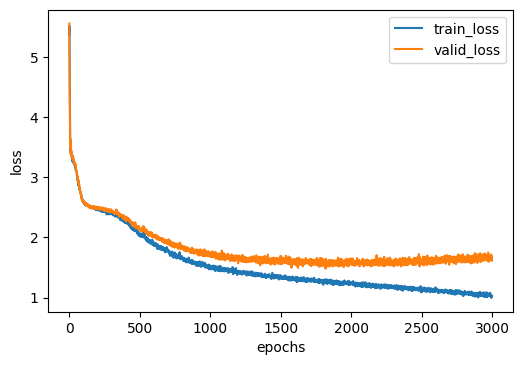

In [18]:
plt.figure(dpi=100)
plt.plot(training_loss, label= "train_loss")
plt.plot(validation_loss, label= "valid_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()